In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
from scipy import integrate
from scipy.stats import chi2
from iminuit import minimize, Minuit
print('chi2 for 1 sigma = ', chi2.isf(1-0.683, 1, loc=0, scale=1))
print('chi2 for 2 sigma = ', chi2.isf(1-0.954, 1, loc=0, scale=1))
print('chi2 for 3 sigma = ', chi2.isf(1-0.997, 1, loc=0, scale=1))

chi2 for 1 sigma =  1.0012840694690475
chi2 for 2 sigma =  3.981594462262515
chi2 for 3 sigma =  8.807468393511947


In [2]:
# Fixed the bins, colors, mass arr, and labels for all plots.
bins_min, bins_max, bins_w = 120, 230, 1
bins = np.arange(bins_min, bins_max+1, bins_w)
bins_mid = bins[:-1]+bins_w/2
bins_dense = np.linspace(bins_min, bins_max, 1000)

mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)
top_mass_chi2 = np.linspace(166, 180, 1000)
sudo_bins = np.arange(166, 180, 0.2)
sudo_bins_dense = np.linspace(166, 180, 1000)

loglikeli_cut = -75
marginal_prob_cut = 0.2

sudo_event = 10000

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
state_labels = ['Unmatched', 'Incorrect', 'Correct']
langau_fit_labels = ['Mean of Landau', 'Variance of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
two_gau_fit_labels = ['Mean of  first Gaussian', 'Variance of first Gaussian', 'Mean of  second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']

In [3]:
def get_reco_top_mass(h5py_file, target): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    100 < reco_m_top < 300
    additional cuts (same as CMS)
    """
    # Caululate delR
    # Caululate delR
#     lepton_eta = h5py_file['lepton_features/eta'][:]
#     lepton_phi = h5py_file['lepton_features/phi'][:]
#     jet_eta = h5py_file['jet_features/eta'][:]
#     jet_phi = h5py_file['jet_features/phi'][:]
#     del_eta = np.array([jet_eta[i, :4] - lepton_eta[i] for i in range(len(jet_eta))])
#     del_phi = np.abs([jet_phi[i, :4] - lepton_phi[i] for i in range(len(jet_eta))])
#     del_phi = np.where(del_phi < np.pi, del_phi, 2*np.pi-del_phi)
#     delR = np.sqrt(del_eta**2 + del_phi**2)

    # cuts
    # pid 11 is electron, 13 is muon.
#     cut_lepton_pt = np.logical_or(
#                         np.logical_and(h5py_file['lepton_features/pt'][:] > 26, h5py_file['lepton_features/pid'][:] == 13),
#                         np.logical_and(h5py_file['lepton_features/pt'][:] > 29, h5py_file['lepton_features/pid'][:] == 11))
#     cut_lepton_eta = np.abs(h5py_file['lepton_features/eta'][:]) < 2.4
#     cut_delR = np.logical_or(np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 13, delR[:, 0] > 0.4, delR[:, 1] > 0.4, delR[:, 2] > 0.4, delR[:, 3] > 0.4)),
#             np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 11, delR[:, 0] > 0.3, delR[:, 1] > 0.3, delR[:, 2] > 0.3, delR[:, 3] > 0.3)))
#     cut_jet_pt = h5py_file['jet_features/pt'][:, 3] > 30
#     cut_jet_eta = np.logical_and.reduce((abs(h5py_file['jet_features/eta'][:, 0]) < 2.4, abs(h5py_file['jet_features/eta'][:, 1]) < 2.4,
#                                         abs(h5py_file['jet_features/eta'][:, 2]) < 2.4, abs(h5py_file['jet_features/eta'][:, 3]) < 2.4))
#     cut_first4_btag = np.sum(h5py_file['jet_features/btag'][:, :4], axis=1) == 2
#     cuts_CMS = np.logical_and.reduce((cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))
#     cuts = np.logical_and.reduce((cut_reco_top, cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))
    cuts = np.logical_and(dic['reconstructed_top_mass'] > bins_min, dic['reconstructed_top_mass'] < bins_max)

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], state, cuts, h5py_file['klfitter/score/loglikelihood'][:]
    elif target == 'spanet': return dic['reconstructed_top_mass'], state, cuts, h5py_file['spanet/right_target/assignment_probability'][:], h5py_file['spanet/right_target/detection_probability'][:], h5py_file['spanet/right_target/marginal_probability'][:]

In [4]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct

reco_spanet_dic, state_spanet_dic, cut_spanet_dic = {}, {}, {}
reco_klf_dic, state_klf_dic, cut_klf_dic = {}, {}, {}
loglikeli_klf_dic, assignment_spanet_dic, detection_spanet_dic, marginal_spanet_dic = {}, {}, {}, {}

for m in mass:
    h5py_file = h5py.File('ttbar_testing_mass_variation/ttbar_testing_{}_gev_with_spanet_pdnn_KLFitter.h5'.format(m), "r")
    reco_spanet_dic[m], state_spanet_dic[m], cut_spanet_dic[m], assignment_spanet_dic[m], detection_spanet_dic[m], marginal_spanet_dic[m] = get_reco_top_mass(h5py_file, 'spanet')
    reco_klf_dic[m], state_klf_dic[m], cut_klf_dic[m], loglikeli_klf_dic[m]  = get_reco_top_mass(h5py_file, 'klfitter')

In [6]:
m = 173
reco_klfm_dic, state_klfm_dic, cut_klfm_dic, loglikeli_klfm_dic = {}, {}, {}, {}
h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(173), "r")
reco_klfm_dic[m], state_klfm_dic[m], cut_klfm_dic[m], loglikeli_klfm_dic[m] = get_reco_top_mass(h5py_file, 'klfitter')

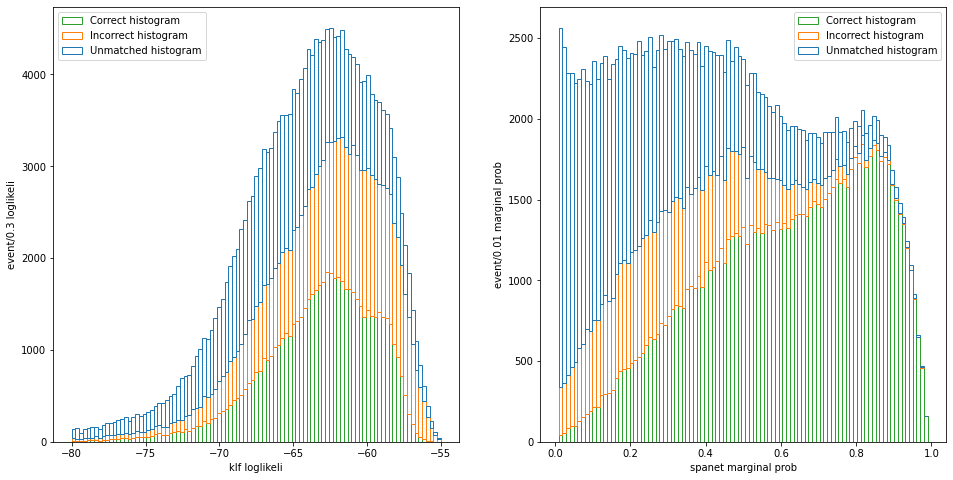

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
m = 173
cuts = np.linspace(-80, -55, 100)
width = cuts[1] - cuts[0]
h_klf = [0]*(len(cuts)-1)
for state_i in [2, 1, 0]:
    hist, _ = np.histogram(loglikeli_klf_dic[m][np.logical_and.reduce((state_klf_dic[m]==state_i, cut_klf_dic[m]))], bins=cuts)
    plt.bar(cuts[:-1]+width/2, hist, bottom=h_klf, edgecolor=colors[state_i], width=width, color='None', label = state_labels[state_i] + ' histogram')
    h_klf += hist
plt.xlabel('klf loglikeli')
plt.ylabel('event/{:.1f} loglikeli'.format(width))
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
cuts = np.linspace(0.01, 0.99, 100)
width = cuts[1] - cuts[0]
h_spanet = [0]*(len(cuts)-1)
for state_i in [2, 1, 0]:
    hist, _ = np.histogram(marginal_spanet_dic[m][np.logical_and.reduce((state_spanet_dic[m]==state_i, cut_spanet_dic[m]))], bins=cuts)
    plt.bar(cuts[:-1]+width/2, hist, bottom=h_spanet, edgecolor=colors[state_i], width=width, color='None', label = state_labels[state_i] + ' histogram')
    h_spanet += hist
plt.xlabel('spanet marginal prob')
plt.ylabel('event/{:.2f} marginal prob'.format(width))
plt.legend(loc='upper right')
plt.show()

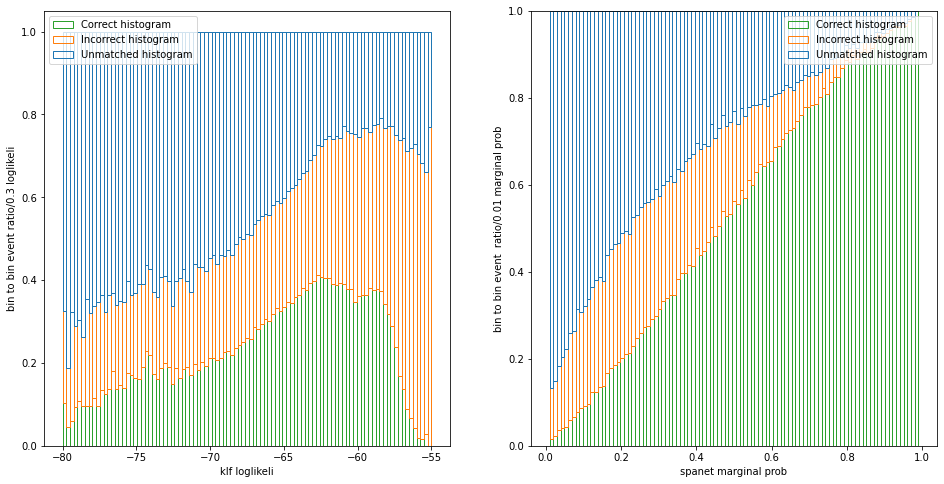

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
m = 173
cuts = np.linspace(-80, -55, 100)
width = cuts[1] - cuts[0]
h_klf_density = [0]*(len(cuts)-1)
for state_i in [2, 1, 0]:
    hist, _ = np.histogram(loglikeli_klf_dic[m][np.logical_and.reduce((state_klf_dic[m]==state_i, cut_klf_dic[m]))], bins=cuts)
    plt.bar(cuts[:-1]+width/2, hist/h_klf, bottom=h_klf_density, edgecolor=colors[state_i], width=width, color='None', label = state_labels[state_i] + ' histogram')
    h_klf_density += hist/h_klf
plt.xlabel('klf loglikeli')
plt.ylabel('bin to bin event ratio/{:.1f} loglikeli'.format(width))
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
cuts = np.linspace(0.01, 0.99, 100)
width = cuts[1] - cuts[0]
h_spanet_density = [0]*(len(cuts)-1)
for state_i in [2, 1, 0]:
    hist, _ = np.histogram(marginal_spanet_dic[m][np.logical_and.reduce((state_spanet_dic[m]==state_i, cut_spanet_dic[m]))], bins=cuts)
    plt.bar(cuts[:-1]+width/2, hist/h_spanet, bottom=h_spanet_density, edgecolor=colors[state_i], width=width, color='None', label = state_labels[state_i] + ' histogram')
    h_spanet_density += hist/h_spanet
plt.xlabel('spanet marginal prob')
plt.ylabel('bin to bin event  ratio/{:.2f} marginal prob'.format(width))
plt.legend(loc='upper right')
plt.show()

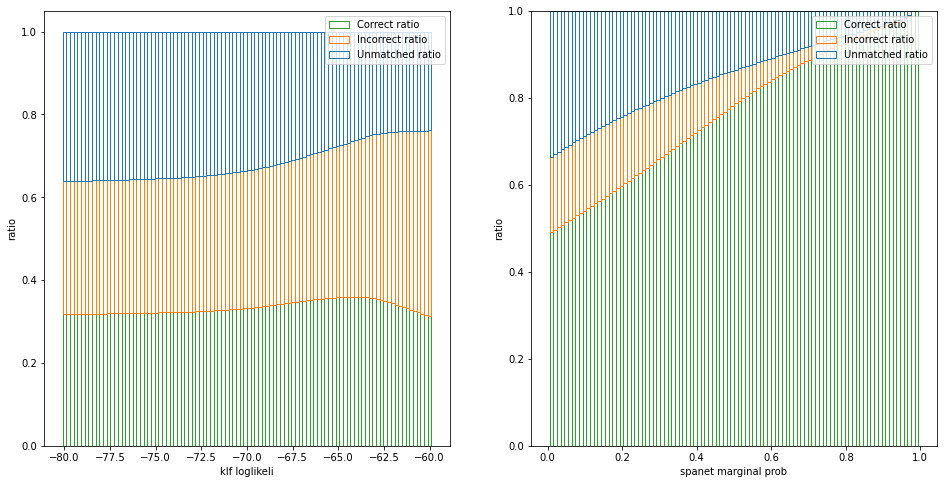

In [9]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
m = 173
tot = []
unmatched = []
incorrect = []
correct = []

cuts = np.linspace(-80, -60, 100)
for cut in cuts:
    tot.append(len(reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>cut))]))
    unmatched.append(len(reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == 0, loglikeli_klf_dic[m]>cut))]))
    incorrect.append(len(reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == 1, loglikeli_klf_dic[m]>cut))]))
    correct.append(len(reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == 2, loglikeli_klf_dic[m]>cut))]))

width = cuts[1] - cuts[0]
tot, unmatched, incorrect, correct = np.array(tot), np.array(unmatched), np.array(incorrect), np.array(correct)
h = [0]*len(tot)
plt.bar(cuts, correct/tot, bottom=h, edgecolor=colors[2], width=width, color='None', label = state_labels[2] + ' ratio')
h += correct/tot
plt.bar(cuts, incorrect/tot, bottom=h, edgecolor=colors[1], width=width, color='None', label = state_labels[1] + ' ratio')
h += incorrect/tot
plt.bar(cuts, unmatched/tot, bottom=h, edgecolor=colors[0], width=width, color='None', label = state_labels[0] + ' ratio')
plt.xlabel('klf loglikeli')
plt.ylabel('ratio')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
tot = []
unmatched = []
incorrect = []
correct = []

cuts = np.linspace(0.01, 0.99, 100)
for cut in cuts:
    tot.append(len(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], marginal_spanet_dic[m]>cut))]))
    unmatched.append(len(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == 0, marginal_spanet_dic[m]>cut))]))
    incorrect.append(len(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == 1, marginal_spanet_dic[m]>cut))]))
    correct.append(len(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == 2, marginal_spanet_dic[m]>cut))]))

width = cuts[1] - cuts[0]
tot, unmatched, incorrect, correct = np.array(tot), np.array(unmatched), np.array(incorrect), np.array(correct)
h = [0]*len(tot)
plt.bar(cuts, correct/tot, bottom=h, edgecolor=colors[2], width=width, color='None', label = state_labels[2] + ' ratio')
h += correct/tot
plt.bar(cuts, incorrect/tot, bottom=h, edgecolor=colors[1], width=width, color='None', label = state_labels[1] + ' ratio')
h += incorrect/tot
plt.bar(cuts, unmatched/tot, bottom=h, edgecolor=colors[0], width=width, color='None', label = state_labels[0] + ' ratio')

plt.xlabel('spanet marginal prob')
plt.ylabel('ratio')
plt.legend(loc='upper right')
plt.show()

0.33384803448497713 0.9780667762036147
0.37835854920107537 0.928650632309845
0.6313513647458215 0.9125067759697958


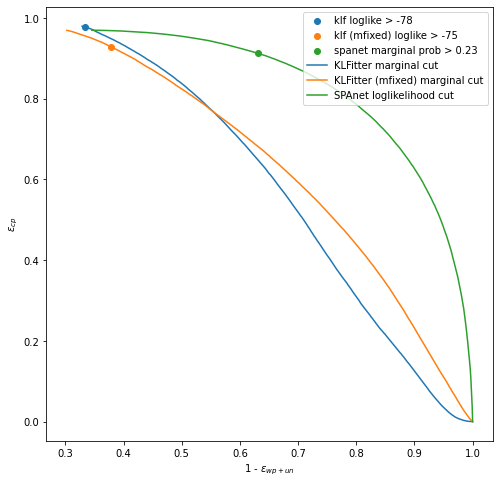

In [20]:
plt.figure(figsize=(8, 8))
eps1_klf = []
eps2_klf = []

eps1_klfm = []
eps2_klfm = []

eps1_spanet = []
eps2_spanet = []

m = 173
tot1 = np.count_nonzero(state_klf_dic[m]!=2)
tot2 = np.count_nonzero(state_klf_dic[m]==2)
for cut in np.linspace(-80, -40, 1000):
    eps1_klf.append(1-len(state_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m]!=2, loglikeli_klf_dic[m]>cut))])/tot1)
    eps2_klf.append(len(state_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m]==2, loglikeli_klf_dic[m]>cut))])/tot2)

cut = -78    
point1 = 1-len(state_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m]!=2, loglikeli_klf_dic[m]>cut))])/tot1
point2 = len(state_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m]==2, loglikeli_klf_dic[m]>cut))])/tot2
print(point1, point2)
plt.scatter(point1, point2, label='klf loglike > -78')

tot1 = np.count_nonzero(state_klfm_dic[m]!=2)
tot2 = np.count_nonzero(state_klfm_dic[m]==2)
for cut in np.linspace(-80, -40, 1000):
    eps1_klfm.append(1-len(state_klfm_dic[m][np.logical_and.reduce((cut_klfm_dic[m], state_klfm_dic[m]!=2, loglikeli_klfm_dic[m]>cut))])/tot1)
    eps2_klfm.append(len(state_klfm_dic[m][np.logical_and.reduce((cut_klfm_dic[m], state_klfm_dic[m]==2, loglikeli_klfm_dic[m]>cut))])/tot2)

cut = -75
point1 = 1-len(state_klfm_dic[m][np.logical_and.reduce((cut_klfm_dic[m], state_klfm_dic[m]!=2, loglikeli_klfm_dic[m]>cut))])/tot1
point2 = len(state_klfm_dic[m][np.logical_and.reduce((cut_klfm_dic[m], state_klfm_dic[m]==2, loglikeli_klfm_dic[m]>cut))])/tot2
print(point1, point2)
plt.scatter(point1, point2, label='klf (mfixed) loglike > -75')

tot1 = np.count_nonzero(state_spanet_dic[m]!=2)
tot2 = np.count_nonzero(state_spanet_dic[m]==2)
for cut in np.linspace(0.01, 0.99, 1000):
    eps1_spanet.append(1-len(state_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m]!=2, marginal_spanet_dic[m]>cut))])/tot1)
    eps2_spanet.append(len(state_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m]==2, marginal_spanet_dic[m]>cut))])/tot2)

cut = 0.23
point1 = 1-len(state_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m]!=2, marginal_spanet_dic[m]>cut))])/tot1
point2 = len(state_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m]==2, marginal_spanet_dic[m]>cut))])/tot2
plt.scatter(point1, point2, label='spanet marginal prob > 0.23')
print(point1, point2)

plt.plot(eps1_klf, eps2_klf, label = 'KLFitter marginal cut')
plt.plot(eps1_klfm, eps2_klfm, label = 'KLFitter (mfixed) marginal cut')
plt.plot(eps1_spanet, eps2_spanet, label = 'SPAnet loglikelihood cut')
plt.xlabel(r'1 - $\epsilon_{wp+un}$')
plt.ylabel(r'$\epsilon_{cp}$')
plt.legend(loc='upper right')
plt.show()

In [ ]:
loglikeli_total_event = defaultdict(list)
loglikeli_correct_number = defaultdict(list)

marginal_total_event = defaultdict(list)
marginal_correct_number = defaultdict(list)

m = 173
for cut in np.linspace(-80, -60, 100):
    loglikeli_total_event[m].append(len(state_klf_dic[m][np.logical_and(cut_klf_dic[m], loglikeli_klf_dic[m]>cut)]))
    loglikeli_correct_number[m].append(np.count_nonzero(state_klf_dic[m][np.logical_and(cut_klf_dic[m], loglikeli_klf_dic[m]>cut)] != 0))

for cut2 in np.linspace(0.1, 0.9, 100):
    marginal_total_event[m].append(len(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], marginal_spanet_dic[m]>cut2)]))
    marginal_correct_number[m].append(np.count_nonzero(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], marginal_spanet_dic[m]>cut2)] != 0))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(loglikeli_total_event[m], loglikeli_correct_number[m], label = 'KLFitter marginal cut')
plt.plot(marginal_total_event[m], marginal_correct_number[m], label = 'SPAnet loglikelihood cut')
plt.xlabel('Total event')
plt.ylabel('Correct number')
plt.legend(loc='upper left')
plt.xlim(20000, 180000)

plt.subplot(1, 2, 2)
plt.plot(loglikeli_total_event[m], np.array(loglikeli_correct_number[m])/loglikeli_total_event[m], label = 'KLFitter marginal cut')
plt.plot(marginal_total_event[m], np.array(marginal_correct_number[m])/marginal_total_event[m], label = 'SPAnet loglikelihood cut')
plt.xlabel('Total event')
plt.ylabel('Correct ratio')
plt.legend(loc='upper right')
plt.xlim(20000, 180000)
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
JSF = 1

plt.subplot(2, 2, 1)
plt.hist(reco_klf_dic[JSF], bins=bins, histtype='step', label='klf')
plt.hist(reco_spanet_dic[JSF], bins=bins, histtype='step', label='spanet')
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)
plt.hist(reco_klf_dic[JSF][np.logical_and.reduce((cut_klf_dic[JSF], loglikeli_klf_dic[JSF]>loglikeli_cut))], bins=bins,  histtype='step', label='klf')
plt.hist(reco_spanet_dic[JSF][np.logical_and.reduce((cut_spanet_dic[JSF], marginal_spanet_dic[JSF]>marginal_prob_cut))], bins=bins,  histtype='step', label='spanet')
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend(loc='upper right')

plt.subplot(2, 2, 3)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend(loc='upper right')


plt.subplot(2, 2, 4)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend(loc='upper right')


In [ ]:
ratio_klf_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in [0, 1, 2]:
        ratio = np.count_nonzero(state_klf_dic[m][np.logical_and(cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut)]==state_i)/len(state_klf_dic[m][np.logical_and(cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut)])
        ratio_klf_dic[state_i].append(ratio)

plt.figure(figsize=(20, 6))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_klf_dic[state_i])
    plt.title('KLF ' + state_labels[state_i])
    plt.xlabel('top mass (GeV)')
    plt.ylabel('ratio')
plt.savefig('./plots_topmass/klf_ratio.png')
plt.show()
ratio_klf = {key:np.mean(ratio_klf_dic[key]) for key in ratio_klf_dic}

In [ ]:
ratio_spanet_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in [0, 1, 2]:
        ratio = np.count_nonzero(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut)]==state_i)/len(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut)])
        ratio_spanet_dic[state_i].append(ratio)

plt.figure(figsize=(20, 6))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_spanet_dic[state_i])
    plt.title('SPANET ' + state_labels[state_i])
    plt.xlabel('top mass (GeV)')
    plt.ylabel('ratio')
plt.savefig('./plots_topmass/spanet_ratio.png')
plt.show()
ratio_spanet = {key:np.mean(ratio_spanet_dic[key]) for key in ratio_spanet_dic}

In [ ]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized between bins_min and bins_max
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, bins_min, bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# Two gaussian distributions.
# Nomalized
def two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

# Normalized between bins_min and bins_max
def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    return two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f)/integrate.quad(two_gau, bins_min, bins_max, args=(gau_loc1, gau_scale1, gau_loc2, gau_scale2, f))[0]

# Gaussian distributions.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

def voigt(x, shift, sigma, gamma):
    return scipy.special.voigt_profile(x - shift, sigma, gamma)

def voigt_norm(x, shift, sigma, gamma):
    return voigt(x, shift, sigma, gamma)/integrate.quad(voigt, bins_min, bins_max, args=(shift, sigma, gamma))[0]

# Linear
def linear(x, a, b):
    return a*x+b

def chi2_pdf(observed, pdf): #observed is the observation, pdf is the normalized height of the bins from pdf.
    n1, _ = np.histogram(observed, bins=bins)
    n2 = pdf*bins_w*len(observed)
    return np.sum((n1-n2)**2/n2)

In [ ]:
# Fit every class of klfitter
fita_klf_dic, fitb_klf_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}

for state_i in [0, 1, 2]:
    popt_klf_arr = []
    perr_klf_arr = []

    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == state_i, loglikeli_klf_dic[m]>loglikeli_cut))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        sigma = np.sqrt(np.histogram(fit_target, bins=bins)[0])/len(fit_target)
        
        # 2Gaussian for correct
        if state_i == 2:
            popt, pcov = optimize.curve_fit(two_gau_norm, bins_mid, hist, sigma=sigma, p0=(180, 10, 170, 25, 0.9), bounds=((120, 5, 140, 18, 0), (200, 18, 200, 35, 1)))
            y_dense = two_gau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, two_gau_norm(bins_mid, *popt))

        # Landau + Gaussian for incorrect and unmatch
        else:
            popt, pcov = optimize.curve_fit(langau_norm, bins_mid, hist, sigma=sigma, p0=(150, 20, 160, 20, 0.9), bounds=((120, 10, 120, 10, 0), (220, 50, 220, 30, 1)))
            y_dense = langau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, langau_norm(bins_mid, *popt))

        popt_klf_arr.append(popt)
        perr_klf_arr.append(np.sqrt(np.diag(pcov)))
        plt.bar(bins[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
        plt.title('klf {}, loglikelihood > {}'.format(state_labels[state_i], loglikeli_cut))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.show()

    popt_klf_arr = np.transpose(np.array(popt_klf_arr))
    fit_popt_dic[state_i] = popt_klf_arr
    perr_klf_arr = np.transpose(np.array(perr_klf_arr))
    fita_klf_arr, fitb_klf_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_klf_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, mass, arr, sigma=perr_klf_arr[i], method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(mass, arr, yerr = perr_klf_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
        y = linear(top_mass_dense, popt[0], popt[1])
        plt.plot(top_mass_dense, y, label='binned linear fit')
        plt.xlabel('True top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(langau_fit_labels[i])
        plt.title('klf parameters fit')
        fita_klf_arr.append(popt[0])
        fitb_klf_arr.append(popt[1])
        plt.legend(loc='upper right')
    plt.show()
    fita_klf_dic[state_i] = fita_klf_arr
    fitb_klf_dic[state_i] = fitb_klf_arr

In [ ]:
# Fit every class of spanet
fita_spanet_dic, fitb_spanet_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}

for state_i in [0, 1, 2]:
    popt_spanet_arr = []
    perr_spanet_arr = []
    
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, marginal_spanet_dic[m]>marginal_prob_cut))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        sigma = np.sqrt(np.histogram(fit_target, bins=bins)[0])/len(fit_target)
        
        # 2Gaussian for correct
        if state_i == 2:
            popt, pcov = optimize.curve_fit(two_gau_norm, bins_mid, hist, sigma=sigma, p0=(180, 10, 170, 25, 0.9), bounds=((120, 5, 140, 18, 0), (200, 18, 200, 35, 1)))
            y_dense = two_gau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, two_gau_norm(bins_mid, *popt))

        # Landau + Gaussian for incorrect and unmatch
        else:
            popt, pcov = optimize.curve_fit(langau_norm, bins_mid, hist, sigma=sigma, p0=(150, 20, 160, 20, 0.9), bounds=((120, 10, 120, 10, 0), (220, 50, 220, 30, 1)))
            y_dense = langau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, langau_norm(bins_mid, *popt))

        popt_spanet_arr.append(popt)
        perr_spanet_arr.append(np.sqrt(np.diag(pcov)))
        plt.bar(bins[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
        plt.title('spanet {}, marginal probability > {}'.format(state_labels[state_i], marginal_prob_cut))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc = 'upper right')
    plt.show()

    popt_spanet_arr = np.transpose(np.array(popt_spanet_arr))
    fit_popt_dic[state_i] = popt_spanet_arr
    perr_spanet_arr = np.transpose(np.array(perr_spanet_arr))
    fita_spanet_arr, fitb_spanet_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_spanet_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, mass, arr, sigma=perr_spanet_arr[i], method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(mass, arr, yerr = perr_spanet_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
        y = linear(top_mass_dense, popt[0], popt[1])
        plt.plot(top_mass_dense, y, label='binned linear fit')
        plt.xlabel('True top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(langau_fit_labels[i])
        plt.title('spanet {}, marginal probability > 0.3'.format(state_labels[state_i]))
        fita_spanet_arr.append(popt[0])
        fitb_spanet_arr.append(popt[1])
        plt.legend(loc='upper right')
    plt.show()
    fita_spanet_dic[state_i] = fita_spanet_arr
    fitb_spanet_dic[state_i] = fitb_spanet_arr

In [ ]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate([172, 173, 173]):
        plt.subplot(2, 4, i+1)
        target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == state_i, loglikeli_klf_dic[m]>loglikeli_cut))]
        hist, bin_edges = np.histogram(target, bins=bins, density=True)
        popt = np.array(fita_klf_dic[state_i])*m+fitb_klf_dic[state_i]
        if state_i  == 2:
            y_template_dense_norm = two_gau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, two_gau_norm(bins_mid, *popt))
        else:
            y_template_dense_norm = langau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))

        plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('KLFitter {}, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

In [ ]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate([172, 173, 174]):
        plt.subplot(2, 4, i+1)
        target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, marginal_spanet_dic[m]>marginal_prob_cut))]
        hist, bin_edges = np.histogram(target, bins=bins, density=True)
        popt = np.array(fita_spanet_dic[state_i])*m+fitb_spanet_dic[state_i]
        if state_i  == 2:
            y_template_dense_norm = two_gau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, two_gau_norm(bins_mid, *popt))
        else:
            y_template_dense_norm = langau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))

        plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('SPANET {}, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

In [ ]:
def combine_klf_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = np.array(fita_klf_dic[state_i])*m + fitb_klf_dic[state_i]
        if state_i == 2: hist += two_gau_norm(x, *popt)*ratio_klf[state_i]
        else: hist += langau_norm(x, *popt)*ratio_klf[state_i]
    return hist

def combine_spanet_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = np.array(fita_spanet_dic[state_i])*m + fitb_spanet_dic[state_i]
        if state_i == 2: hist += two_gau_norm(x, *popt)*ratio_spanet[state_i]
        else: hist += langau_norm(x, *popt)*ratio_spanet[state_i]
    return hist

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))]
    klf_pdf = combine_klf_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_klf_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [0, 1, 2]:
        hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((state_klf_dic[m] == state_i, cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, klf_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('klfitter, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))]
    spanet_pdf = combine_spanet_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_spanet_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [0, 1, 2]:
        hist, _ = np.histogram(reco_spanet_dic[m][np.logical_and.reduce((state_spanet_dic[m] == state_i, cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, spanet_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('SPANET, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

In [ ]:
def chi2_klf_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_klf_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

def chi2_spanet_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_spanet_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

In [ ]:
n = 180000
m = 173
plt.figure(figsize=(10, 6))
sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))][:n]
n1 = np.histogram(sudo_klf, bins=bins)[0]
# n1 = combine_klf_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)

minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='klf best fit = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))

sudo_spanet = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))][:n]
n1 = np.histogram(sudo_spanet, bins=bins)[0]
# n1 = combine_spanet_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)

minuit = Minuit(chi2_spanet_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='spanet best fit = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))

plt.axhline(1, c='r')
plt.title(r'Template $\chi^2$, select first 180000')
plt.xlabel('top mass (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()

In [ ]:
m = 173
sudo_spanet = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))]
n1 = np.histogram(sudo_spanet, bins=bins)[0]
n1 = combine_spanet_pdf_func(bins_mid, m)*len(sudo_spanet)*bins_w
minuit = Minuit(chi2_spanet_arr_func_n, m=m, N=np.sum(n1))
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.axhline(1, c='r')
plt.scatter(minuit.values['m'], 0, label='best fit = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
plt.title('Without additional cuts')
plt.xlabel('top mass (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()
print(minuit.values['N'])
print(minuit.errors['N'])

In [ ]:
#Sudo experiment for KLFitter top mass
sudo_klf_top_mean_dic = {}
sudo_klf_top_std_dic = {}

for m in mass:
    sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))]
    n1_arr = np.random.poisson(np.histogram(sudo_klf, bins=bins)[0], size=(sudo_event, (bins_max-bins_min)//bins_w))
    mean, std = [], []
    for i in range(sudo_event):
        n1 = n1_arr[i]
        minuit = Minuit(chi2_klf_arr_func_n, m=m, N=np.sum(n1))
        minuit.migrad()
        minuit.hesse()
        minuit.minos()
        mean.append(minuit.values['m'])
        std.append(minuit.errors['m'])
    sudo_klf_top_mean_dic[m] = mean
    sudo_klf_top_std_dic[m] = std

In [ ]:
m = 173
print(sudo_klf_top_mean_dic[m][0])
print(sudo_klf_top_std_dic[m][0])

In [ ]:
plt.errorbar(mass, [np.mean(sudo_klf_top_mean_dic[m])-m for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m])/np.sqrt(sudo_event) for m in mass])
plt.title('bias for different top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

In [ ]:
plt.figure(figsize = (6, 6))

klf_top_bias = np.mean([np.mean(sudo_klf_top_mean_dic[m])-m for m in mass])
klf_top_pull = [(np.array(sudo_klf_top_mean_dic[m])-m-klf_top_bias)/sudo_klf_top_std_dic[m] for m in mass]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
plt.title('klfitter top mass pull histogram')
plt.xlim(-10, 10)
plt.xlabel('top mass pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Sudo experiment for KLFitter top mass
sudo_klf_top_pdf_mean_dic = {}
sudo_klf_top_pdf_std_dic = {}

for m in mass:
    sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))]
    sudo_klf_pdf = combine_klf_pdf_func(bins_mid, m)*len(sudo_klf)*bins_w
    n1_arr = np.random.poisson(combine_klf_pdf_func(bins_mid, m)*len(sudo_klf)*bins_w, size=(sudo_event, (bins_max-bins_min)//bins_w))
    mean, std = [], []
    for i in range(sudo_event):
        n1 = n1_arr[i]
        minuit = Minuit(chi2_klf_arr_func_n, m=m, N=np.sum(n1))
        minuit.migrad()
        minuit.hesse()
        minuit.minos()
        mean.append(minuit.values['m'])
        std.append(minuit.errors['m'])
    sudo_klf_top_pdf_mean_dic[m] = mean
    sudo_klf_top_pdf_std_dic[m] = std

In [ ]:
plt.figure(figsize = (6, 6))

klf_top_bias = np.mean([np.mean(sudo_klf_top_pdf_mean_dic[m])-m for m in mass])
klf_top_pull = [(np.array(sudo_klf_top_pdf_mean_dic[m])-m-klf_top_bias)/sudo_klf_top_pdf_std_dic[m] for m in mass]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-5, 5, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
plt.title('klfitter top mass pull histogram (sudo from pdf)')
plt.xlim(-5, 5)
plt.xlabel('top mass pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()